# TODOs

* Per dataframe inspection function

In [1]:
from polars_utils import Pipe, inspect_df
import polars as pl 

In [12]:
t = pl.scan_csv("world_bank_gdp_data.csv")
from types import SimpleNamespace
from types import ModuleType
class Schema(SimpleNamespace):
    def __init__(self, df):
        super().__init__(**{k:k for k in df.columns})
    def __dir__(self):
        return [s for s in super().__dir__() if not s.startswith('_')]
# class Schema(SimpleNamespace):
#     def __init__(self, df):
#         super().__init__(**{k:k for k in df.columns})
#     def __dir__(self):
#         return [s for s in super().__dir__() if not s.startswith('_')]
    
x = Schema(t)

In [2]:
input = Pipe(pl).scan_csv("world_bank_gdp_data.csv")

input = input.select(
    pl.col("Country Code").alias("Country"),
    pl.col("^[0-9]+.*$").cast(pl.Float32, strict=False).map_alias(lambda s: s[:4]))

input = input.melt(id_vars=["Country"], variable_name="Date", value_name="GDP") #, "pivot tall"

input = input.select(
    pl.col("Country"),
    pl.col("Date").cast(pl.Int32),
    pl.col("*").exclude("Country", "Date")
) #, "cast dates to number"

input = input.drop_nulls().sort(by=["Country", "Date"]) #, "drop nulls and sort"

inspect_df(input, lambda x: x.head().collect())


# input_limited = input.filter(pl.col("Country")=="USA")



In [4]:
calc = input.copy()

with calc.group("Country") as grp:
    grp['diff']     = pl.col("GDP") - pl.col("GDP").shift(1)
    grp['diff_avg'] = pl.col('diff').rolling_mean(5)

def adjust(df):
    if "Country" in df.columns:
        return df.filter(pl.col("Country")=="USA").head(10).collect()
    else:
        return df.head(10).collect()

inspect_df(calc, adjust)

In [12]:
def plot(df, date_col, columns):
    df.collect().to_pandas().set_index(date_col)[columns].plot()

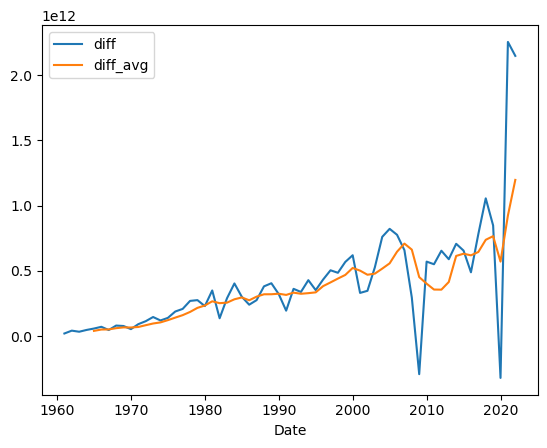

In [13]:
plot(calc.filter(pl.col("Country") == "USA"), "Date", ["diff","diff_avg"])

In [152]:
# df = pn.scan_csv("world_bank_gdp_data.csv")
# df            = df.sel[["Country Code"]]
# df["Country"] = df["Country Code"]

In [5]:
# dfx.inplace.select([pl.col("Country Code"), pl.col("1960 [YR1960]")])


In [37]:
# Potential alternate view. But clicking on nodes is scrolling to the top of the notebook. 
# Blocking bug until I figure that out

# from ipytree import Tree, Node
# tree = Tree(stripes=True)
# tree 
# #
# curr_tree = tree
# curr = df
# def handle_click(event):
#     print(event['owner'].name)

# while hasattr(curr, 'parent'):
#     node = Node(curr.parent_attr)
#     node.observe(handle_click, 'selected')
#     curr_tree.add_node(node)

#     curr_tree = node
#     curr = curr.parent